In [ ]:
# ================================
# 📦 Basic Imports & Drive Mount
# ================================

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Mounted at /content/drive


device(type='cpu')

In [ ]:
# ==================================
# 📁 Set data directory paths
# ==================================

DATA_ROOT = "/content/drive/MyDrive/EEG_Speech_Dataset"
ARTIC_DIR = f"{DATA_ROOT}/Articulatory"
GENERAL_DIR = f"{DATA_ROOT}/General"

print("Articulatory files:", os.listdir(ARTIC_DIR)[:10])
print("General files:", os.listdir(GENERAL_DIR)[:10])


Articulatory files: ['sub-01_trajectories.csv', 'sub-01_features.npy', 'sub-02_features.npy', 'sub-03_trajectories.csv', 'sub-03_features.npy', 'sub-04_trajectories.csv', 'sub-04_features.npy', 'sub-05_features.npy', 'sub-05_trajectories.csv', 'sub-06_trajectories.csv']
General files: ['sub-03_electrode_locations.csv', 'sub-05_channel_names.npy', 'sub-07_electrode_locations.csv', 'sub-15_channel_names.npy', 'sub-06_channel_names.npy', 'sub-08_channel_names.npy', 'sub-12_electrode_locations.csv', 'sub-08_electrode_locations.csv', 'sub-07_channel_names.npy', 'sub-03_channel_names.npy']


Semantic Loader

In [ ]:
import os
import numpy as np

def load_semantic_data(subject_id, data_root):
    """
    Load EEG → Semantic frame-level data for one subject.

    Returns:
        eeg (np.ndarray): EEG features, shape (N_frames, D_eeg)
        semantic (np.ndarray): Word2Vec-style semantic features, shape (N_frames, 157 or 160)
        labels (np.ndarray): Frame-to-trial mapping, shape (N_frames,)
    """

    # === EEG features for semantic task ===
    eeg = np.load(os.path.join(data_root, "Semantic", f"{subject_id}_features.npy"))

    # === Semantic targets ===
    semantic = np.load(os.path.join(data_root, "Semantic", f"{subject_id}_semantic.npy"))

    # === Frame labels (for trial grouping, optional) ===
    labels = np.load(os.path.join(data_root, "Semantic", f"{subject_id}_labels.npy"))

    return eeg, semantic, labels


Print shapes of all semantic files

In [ ]:
import os

for root, dirs, files in os.walk("/content", topdown=True):
    for f in files:
        if "sub-15_features.npy" in f:
            print("FOUND →", os.path.join(root, f))


FOUND → /content/drive/MyDrive/EEG_Speech_Dataset/Semantic/sub-15_features.npy
FOUND → /content/drive/MyDrive/EEG_Speech_Dataset/Articulatory/sub-15_features.npy
FOUND → /content/drive/MyDrive/EEG_Speech_Dataset/Acoustic/sub-15_features.npy


In [ ]:
import numpy as np
import os

DATA_ROOT = "/content/drive/MyDrive/EEG_Speech_Dataset/Semantic"
sub = "sub-15"

# File paths
features_path = os.path.join(DATA_ROOT, f"{sub}_features.npy")
labels_path   = os.path.join(DATA_ROOT, f"{sub}_labels.npy")
words_path    = os.path.join(DATA_ROOT, "words.txt")
vecs_path     = os.path.join(DATA_ROOT, "vecs.npy")

# Load
eeg = np.load(features_path)
labels = np.load(labels_path)
words = [line.strip() for line in open(words_path)]
vecs = np.load(vecs_path)

print("EEG features:", eeg.shape)
print("Labels:", labels.shape)
print("Unique labels:", len(np.unique(labels)))
print("words.txt count:", len(words))
print("vecs.npy shape:", vecs.shape)


EEG features: (12011, 65)
Labels: (12011,)
Unique labels: 101
words.txt count: 121
vecs.npy shape: (121, 160)


In [ ]:
import numpy as np
import os

DATA_ROOT = "/content/Data/Semantic"  # change if needed
sub = "sub-15"

# File paths
features_path = os.path.join(DATA_ROOT, f"{sub}_features.npy")
labels_path   = os.path.join(DATA_ROOT, f"{sub}_labels.npy")
words_path    = os.path.join(DATA_ROOT, "words.txt")
vecs_path     = os.path.join(DATA_ROOT, "vecs.npy")

# Load
eeg = np.load(features_path)
labels = np.load(labels_path)
words = [line.strip() for line in open(words_path)]
vecs = np.load(vecs_path)

print("EEG features:", eeg.shape)
print("Labels:", labels.shape)
print("Unique labels:", len(np.unique(labels)))
print("words.txt count:", len(words))
print("vecs.npy shape:", vecs.shape)



Inspect the LABELS and WORDS

Show the first 50 labels

In [ ]:
print(labels[:50])


[b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r'
 b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r'
 b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r'
 b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r'
 b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r'
 b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r'
 b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r'
 b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r' b'bakker\r'
 b'bakker\r' b'bakker\r']


Show all unique labels

In [ ]:
unique_labels = np.unique(labels)
print("Unique labels:", unique_labels)


Unique labels: [b'' b'11\r' b'12\r' b'2\r' b'3\r' b'5\r' b'6\r' b'7\r' b'8\r' b'9\r'
 b'`s morgens\r' b'aan\r' b'al\r' b'alsof\r' b'bakker\r' b'betovering\r'
 b'bevrijd\r' b'braadde\r' b'buurt\r' b'daarna\r' b'dak\r' b'dakker\r'
 b'dan\r' b'dat\r' b'dauwdruppel\r' b'deur' b'dichtbij\r' b'die\r'
 b'direct\r' b'donkere\r' b'doodsbang\r' b'door\r' b'en\r' b'er\r'
 b'geen\r' b'gefluit\r' b'haar\r' b'had\r' b'helemaal\r' b'helft\r'
 b'hem\r' b'hierop\r' b'hij\r' b'hoe\r' b'hun\r' b'in\r' b'kin\r'
 b'komt\r' b'kwamen\r' b'lij\r' b'maar\r' b'meisjes\r' b'mij\r' b'mijn\r'
 b'moment\r' b'mooi\r' b'naar\r' b'nachtegalen\r' b'niet\r' b'nog\r'
 b'nu\r' b'of\r' b'onmiddellijk\r' b'onschuldig\r' b'ook\r' b'over\r'
 b'pak\r' b'redetwisten\r' b'sok\r' b'spreuk\r' b'sprong\r' b'sterkste\r'
 b'stiekem\r' b'stilstaan\r' b'struik\r' b'tak\r' b'te\r'
 b'teruggekregen\r' b'tot\r' b'totdat\r' b'tuwiet\r' b'uittrekken\r'
 b'van\r' b'vlakbij\r' b'vloog\r' b'vogeltje\r' b'voor\r' b'wanneer\r'
 b'was\r' b'wat\r'

Show how many frames each word appears in

In [ ]:
import numpy as np
from collections import Counter

label_counts = Counter(labels)
for w, c in list(label_counts.items())[:15]:
    print(w, ":", c)


b'bakker\r' : 77
b'' : 4012
b'buurt\r' : 80
b'moment\r' : 80
b'2\r' : 80
b'die\r' : 80
b'doodsbang\r' : 80
b'aan\r' : 80
b'haar\r' : 80
b'kin\r' : 80
b'dakker\r' : 80
b'6\r' : 80
b'hoe\r' : 80
b'maar\r' : 80
b'en\r' : 80


Plot histogram of label frequencies

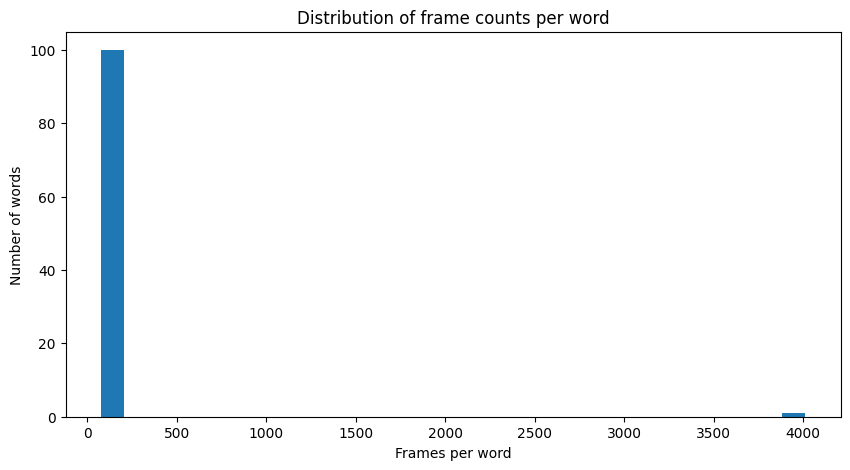

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(list(label_counts.values()), bins=30)
plt.title("Distribution of frame counts per word")
plt.xlabel("Frames per word")
plt.ylabel("Number of words")
plt.show()


Inspect vecs.npy (semantic embeddings)

Show first few embeddings

In [ ]:
print(vecs[:5])


[[-5.41939996e-02  7.11679980e-02  6.13959990e-02 -4.50609997e-02
   1.15258999e-01  1.39358997e-01  2.44027004e-01  2.96199992e-02
  -1.06262997e-01 -7.91369975e-02  1.67939998e-02  2.30679996e-02
   1.20430002e-02 -6.21570013e-02  2.06020009e-02 -8.82999972e-03
  -6.76480010e-02  1.30746007e-01 -3.96119989e-02  3.06330007e-02
  -4.24439982e-02  2.70540006e-02  7.21049979e-02  2.78869998e-02
   1.66105002e-01  3.18170004e-02  5.03260009e-02  1.97878003e-01
  -1.97049994e-02 -5.52010015e-02 -2.05559991e-02  6.49830028e-02
  -5.04150018e-02  2.95509994e-02  1.78231001e-01 -1.01426996e-01
  -4.54800017e-02  7.74590001e-02 -1.24909999e-02  9.77070034e-02
  -4.04709987e-02  1.45815998e-01 -2.21619997e-02  4.35420014e-02
  -1.63185000e-01  1.02348000e-01 -9.89250019e-02  5.92559986e-02
   1.89389996e-02 -2.55420003e-02  1.97340008e-02 -1.94179993e-02
   1.57792002e-01  1.06792003e-01 -2.91360002e-02  9.26660001e-02
  -8.17070007e-02 -2.67799990e-03  1.10714003e-01  6.48100022e-03
  -1.26120

Check range of values

In [ ]:
print("Min:", vecs.min(), "Max:", vecs.max())


Min: -0.3062329888343811 Max: 0.304733008146286


Print the actual norms directly


In [ ]:
import numpy as np

norms = np.linalg.norm(vecs, axis=1)

print("Raw norms:", norms[:20])        # first 20 norms
print("Min norm:", norms.min())
print("Max norm:", norms.max())
print("Mean norm:", norms.mean())


Raw norms: [1.00000014 0.99999994 1.00000069 0.99999976 1.00000015 0.9999998
 0.99999943 1.00000004 1.00000001 0.99999996 0.9999997  0.9999998
 1.00000009 0.99999984 1.00000037 1.00000045 0.99999993 1.00000021
 0.99999982 0.99999992]
Min norm: 0.9999992237481409
Max norm: 1.0000006869020575
Mean norm: 1.000000025432014


In [ ]:
print("Example vector:", vecs[0])
print("Sum of squares:", np.sum(vecs[0]**2))
print("Norm:", np.sqrt(np.sum(vecs[0]**2)))


Example vector: [-0.054194    0.071168    0.061396   -0.045061    0.115259    0.139359
  0.244027    0.02962    -0.106263   -0.079137    0.016794    0.023068
  0.012043   -0.062157    0.020602   -0.00883    -0.067648    0.13074601
 -0.039612    0.030633   -0.042444    0.027054    0.072105    0.027887
  0.166105    0.031817    0.050326    0.197878   -0.019705   -0.055201
 -0.020556    0.064983   -0.050415    0.029551    0.178231   -0.101427
 -0.04548     0.077459   -0.012491    0.097707   -0.040471    0.145816
 -0.022162    0.043542   -0.163185    0.102348   -0.098925    0.059256
  0.018939   -0.025542    0.019734   -0.019418    0.157792    0.106792
 -0.029136    0.092666   -0.081707   -0.002678    0.110714    0.006481
 -0.012612   -0.062906    0.097349    0.012009   -0.027219    0.008514
  0.064109    0.017096   -0.027688    0.003592    0.049364   -0.014035
  0.033273    0.059105   -0.027766   -0.080828   -0.078035    0.053646
 -0.047652   -0.146267   -0.112245    0.03998    -0.083466 

Check if labels match words.txt perfectly

In [ ]:
labels_clean = np.array([l.decode().strip() for l in labels])
words_clean = [w.strip() for w in words]
[x for x in labels_clean if x not in words_clean]


[np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.str_(''),
 np.st

Words never used by this subject

In [ ]:
words_not_used = [w for w in words if w not in unique_labels]
print("Words unused by this subject:", words_not_used[:20])


Words unused by this subject: ['groen', 'ook', 'aan', 'schold', 'verlost', 'hij', 'meisjes', 'een', 'zijn', 'terugvinden', 'bakker', 'redetwisten', 'nachtegalen', 'nu', 'dichtbij', 'die', 'binnenplaats', 'helft', 'tussen', 'kin']


Inspect EEG distribution

In [ ]:
print("EEG mean:", eeg.mean())
print("EEG std:", eeg.std())
print("EEG min:", eeg.min(), "EEG max:", eeg.max())


EEG mean: 1.7086897228664146
EEG std: 1.2706693471594803
EEG min: 0.4295818191609154 EEG max: 12.637789860807167


Plot distribution for a single EEG channel

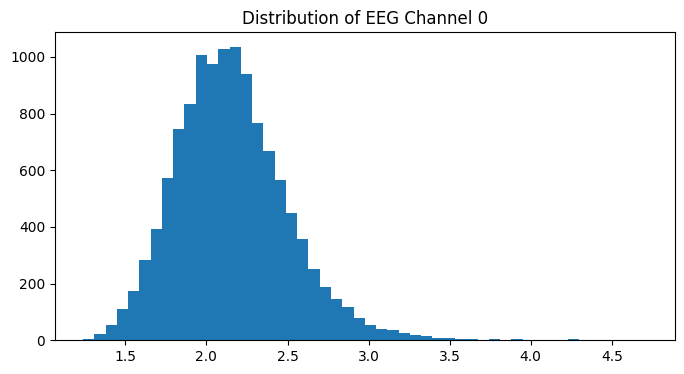

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(eeg[:,0], bins=50)
plt.title("Distribution of EEG Channel 0")
plt.show()


Visualize the raw EEG time series for 1 channel

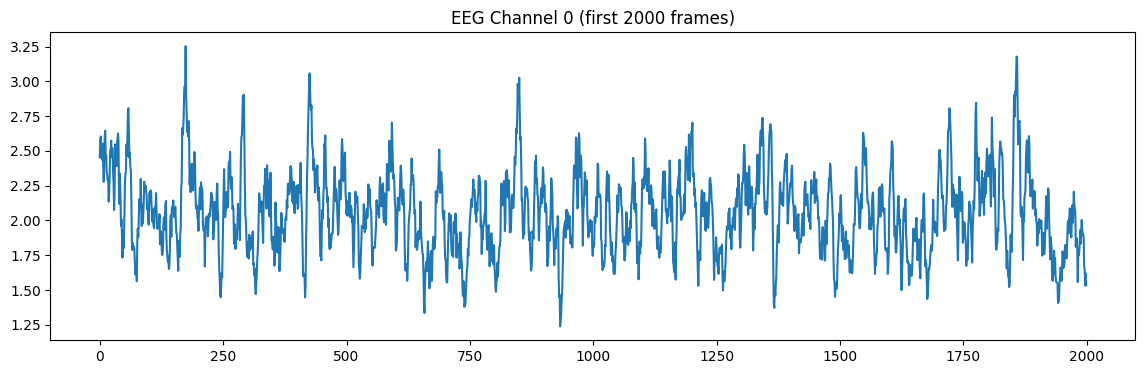

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(eeg[:2000, 0])
plt.title("EEG Channel 0 (first 2000 frames)")
plt.show()


Are some channels dominating?

[0.12099244 0.05627694 0.03590869 0.03134472 0.02895447 0.0378685
 0.05873074 0.0302851  0.02219637 0.01763319 0.11914492 0.4146124
 1.39283803 0.34204633 0.07216337 0.05685612 0.05963901 0.12538011
 0.09669576 0.02345722 0.01618914 0.0096165  0.0118244  0.01033352
 0.01023809 0.02703127 0.02687104 0.05159724 0.07218061 0.35730157
 0.26721411 0.09635031 0.10054974 0.02912409 0.01983028 0.0241052
 0.01940667 0.02265238 0.03323486 0.07222331 1.03238754 0.2662283
 1.49063951 0.18886883 0.02888608 0.03696602 0.03076516 0.02490321
 0.02353075 0.02239041 0.02879775 0.0284263  0.02910655 0.07708042
 1.34998554 0.17049759 0.03276277 0.01795967 0.01754531 0.01188136
 0.01485806 0.07198809 0.01747802 0.01875323 0.01962231]


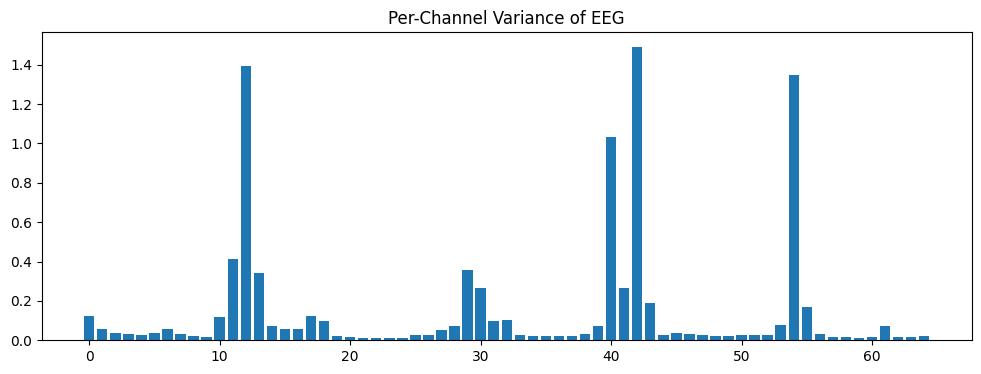

In [ ]:
channel_var = eeg.var(axis=0)
print(channel_var)

plt.figure(figsize=(12,4))
plt.bar(np.arange(len(channel_var)), channel_var)
plt.title("Per-Channel Variance of EEG")
plt.show()


channel 0

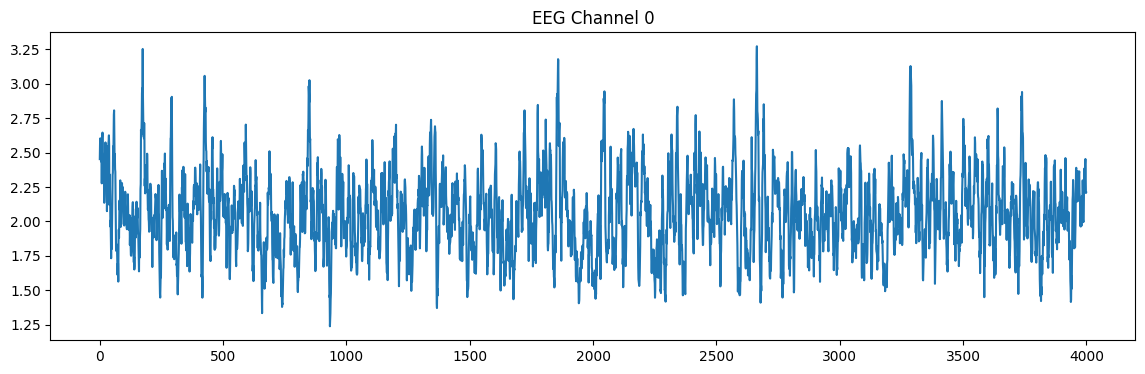

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(eeg[:4000, 0])
plt.title("EEG Channel 0")
plt.show()



Channel 12 (one of the high-variance channels)

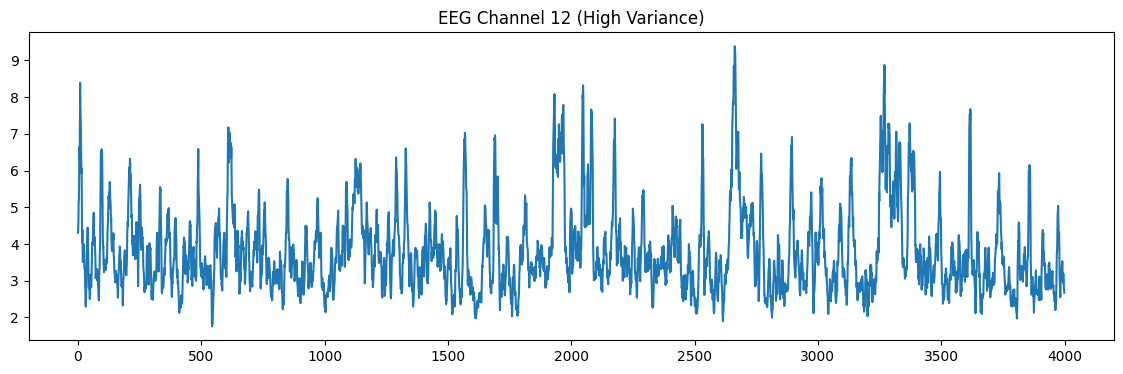

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(eeg[:4000, 12])
plt.title("EEG Channel 12 (High Variance)")
plt.show()


Channel 40 (another high-variance channel)

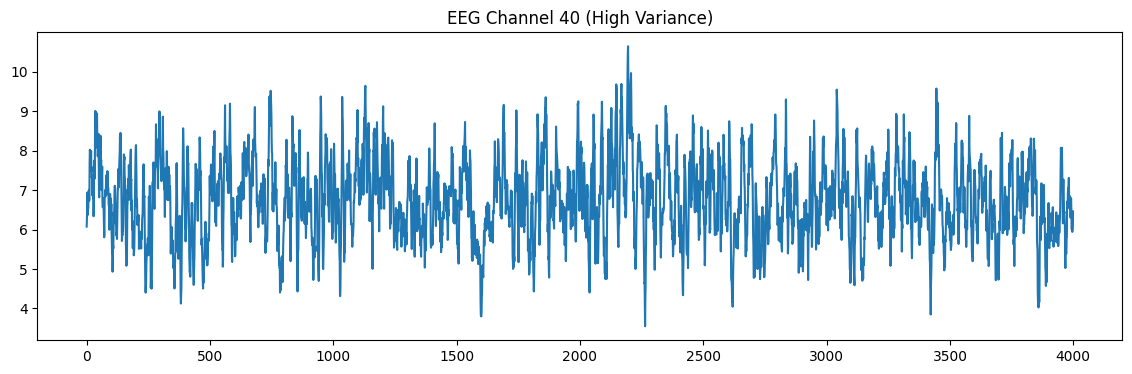

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(eeg[:4000, 40])
plt.title("EEG Channel 40 (High Variance)")
plt.show()


In [ ]:
labels[:50]


array([b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r',
       b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r', b'bakker\r'],
      dtype='|S15')

In [ ]:
raw = np.load(labels_path, allow_pickle=True)
raw[:50]
raw.shape


(12011,)

In [ ]:
word2vec_matrix = np.load(vecs_path)
with open(words_path, "r") as f:
    word_list = [w.strip() for w in f.readlines()]


In [ ]:
print(word2vec_matrix.shape)
print(len(word_list))



(121, 160)
121


###  Load Word2Vec Embeddings  
This cell loads the semantic word embeddings used for the EEG → Meaning (semantic) decoder.

- `vecs.npy` contains the **160-dim word vectors** for all 121 words  
- `words.txt` contains the corresponding **word list**, one word per line  
- We build a dictionary mapping **word → embedding** for fast lookup


In [ ]:
# Load Word2Vec vectors and word list
vecs_path = os.path.join(DATA_ROOT, "vecs.npy")
words_path = os.path.join(DATA_ROOT, "words.txt")

word2vec_matrix = np.load(vecs_path)

with open(words_path, "r") as f:
    word_list = [w.strip() for w in f.readlines()]

word2vec_dict = {word_list[i]: word2vec_matrix[i] for i in range(len(word_list))}

print("Words in word2vec:", len(word2vec_dict))
print("Example:", list(word2vec_dict.items())[:5])


Words in word2vec: 121
Example: [('groen', array([-0.054194  ,  0.071168  ,  0.061396  , -0.045061  ,  0.115259  ,
        0.139359  ,  0.244027  ,  0.02962   , -0.106263  , -0.079137  ,
        0.016794  ,  0.023068  ,  0.012043  , -0.062157  ,  0.020602  ,
       -0.00883   , -0.067648  ,  0.13074601, -0.039612  ,  0.030633  ,
       -0.042444  ,  0.027054  ,  0.072105  ,  0.027887  ,  0.166105  ,
        0.031817  ,  0.050326  ,  0.197878  , -0.019705  , -0.055201  ,
       -0.020556  ,  0.064983  , -0.050415  ,  0.029551  ,  0.178231  ,
       -0.101427  , -0.04548   ,  0.077459  , -0.012491  ,  0.097707  ,
       -0.040471  ,  0.145816  , -0.022162  ,  0.043542  , -0.163185  ,
        0.102348  , -0.098925  ,  0.059256  ,  0.018939  , -0.025542  ,
        0.019734  , -0.019418  ,  0.157792  ,  0.106792  , -0.029136  ,
        0.092666  , -0.081707  , -0.002678  ,  0.110714  ,  0.006481  ,
       -0.012612  , -0.062906  ,  0.097349  ,  0.012009  , -0.027219  ,
        0.008514  ,  

###  Semantic Word2Vec Vocabulary

This section loads the 121-word vocabulary used in the semantic task and the
corresponding 160-dimensional Word2Vec embeddings.

- `words.txt` contains the list of words (121 entries)
- `vecs.npy` contains the 160-dim embeddings in the exact same order
- We build a dictionary `{word → 160-dim vector}` for later retrieval

These embeddings are used as targets for the semantic EEG → meaning decoder.


In [ ]:
import os
import numpy as np

# === Correct Paths (NO double "Semantic") ===
words_path = "/content/drive/MyDrive/EEG_Speech_Dataset/Semantic/words.txt"
vecs_path = "/content/drive/MyDrive/EEG_Speech_Dataset/Semantic/vecs.npy"

# --- Load list of words ---
with open(words_path, "r") as f:
    words = [w.strip() for w in f.readlines()]

# --- Load Word2Vec matrix (121 x 160) ---
vecs = np.load(vecs_path)

# --- Build dictionary: word → 160-dim vector ---
word2vec = {word: vecs[i] for i, word in enumerate(words)}

# --- Diagnostics ---
print("Words in vocabulary:", len(words))
print("Embedding matrix shape:", vecs.shape)
print("\nExample entries:")
for k in list(word2vec.keys())[:5]:
    print(k, word2vec[k][:5], "...")


Words in vocabulary: 121
Embedding matrix shape: (121, 160)

Example entries:
groen [-0.054194  0.071168  0.061396 -0.045061  0.115259] ...
ook [0.059638   0.12978999 0.074967   0.044374   0.15827   ] ...
aan [ 0.041439    0.18740299 -0.090002    0.077193    0.076332  ] ...
schold [0.170508   0.070919   0.15926801 0.089231   0.12583099] ...
verlost [-0.024768    0.176036    0.16023301  0.083961    0.212283  ] ...


###  Inspecting Semantic Labels (labels.npy)

This block loads the semantic labels (one word per EEG frame) and checks:

- How many frames
- Unique labels
- Whether each label exists in the 121-word vocabulary
- Count of invalid / empty / unexpected labels
- How many times each valid word appears

This helps identify alignment mistakes before training the semantic decoder.


In [ ]:
import numpy as np
from collections import Counter

# Paths
labels_path = "/content/drive/MyDrive/EEG_Speech_Dataset/Semantic/sub-15_labels.npy"

# Load labels
labels = np.load(labels_path)

print("Total semantic frames:", len(labels))

# Normalize: decode bytes → string and strip whitespace
labels_clean = [str(l, 'utf-8').strip() for l in labels]

print("Total unique labels:", len(set(labels_clean)))

# Compare with vocab
valid_words = set(word2vec.keys())
unique_labels = set(labels_clean)

invalid_labels = sorted(list(unique_labels - valid_words))

print("\nInvalid labels (not in 121-word vocabulary):")
print(invalid_labels[:30], "...")
print("Count invalid:", len(invalid_labels))

# Count frequency of all labels
freq = Counter(labels_clean)

print("\nMost common labels:")
print(freq.most_common(20))

print("\nEmpty labels count:", freq[""])


Total semantic frames: 12011
Total unique labels: 101

Invalid labels (not in 121-word vocabulary):
['', '11', '12', '2', '3', '5', '6', '7', '8', '9', '`s morgens', 'braadde', 'dakker', 'tuwiet', 'zanddak'] ...
Count invalid: 15

Most common labels:
[('', 4012), ('of', 81), ('wel', 81), ('buurt', 80), ('moment', 80), ('2', 80), ('die', 80), ('doodsbang', 80), ('aan', 80), ('haar', 80), ('kin', 80), ('dakker', 80), ('6', 80), ('hoe', 80), ('maar', 80), ('en', 80), ('naar', 80), ('pak', 80), ('zanddak', 80), ('sterkste', 80)]

Empty labels count: 4012


###  Semantic Dataset Cleaning (EEG → Word2Vec)

This cell performs full preprocessing of the semantic dataset:

1. **Load raw EEG frames**  
   - `sub-15_features.npy` contains 65-dim EEG vectors for each semantic frame  
   - `sub-15_labels.npy` contains the corresponding word labels (bytes)

2. **Load vocabulary + Word2Vec embeddings**  
   - `words.txt` → 121-word vocabulary  
   - `vecs.npy` → 160-dim Word2Vec embeddings aligned with the vocabulary

3. **Cleaning Steps**
   - Remove empty labels (`''`)
   - Remove numeric artifacts (`"2"`, `"3"`, `"7"`, etc.)
   - Convert byte labels → clean strings (strip `\r`)
   - Keep only labels that exist in the official 121-word vocabulary

4. **Output**
   - `eeg_clean`: cleaned EEG matrix `(N_clean, 65)`
   - `labels_clean`: cleaned label strings `(N_clean,)`
   - `targets`: Word2Vec target matrix `(N_clean, 160)`

This cleaned dataset will be used to build the **SemanticFrameDataset** for training the EEG → Word2Vec semantic decoder.


In [ ]:
import numpy as np
import os

# ==== Paths ====
SEMANTIC_ROOT = "/content/drive/MyDrive/EEG_Speech_Dataset/Semantic"

# ==== Load semantic EEG and labels ====
eeg = np.load(os.path.join(SEMANTIC_ROOT, "sub-15_features.npy"))
labels = np.load(os.path.join(SEMANTIC_ROOT, "sub-15_labels.npy"))

print(f"EEG shape (raw): {eeg.shape}")
print(f"Labels shape (raw): {labels.shape}")

# ==== Load vocabulary + word2vec ====
with open(os.path.join(SEMANTIC_ROOT, "words.txt")) as f:
    vocab = [w.strip() for w in f.readlines()]

vecs = np.load(os.path.join(SEMANTIC_ROOT, "vecs.npy"))
word2vec = {vocab[i]: vecs[i] for i in range(len(vocab))}

# ==== Step 1: Drop EMPTY labels ====
mask_not_empty = labels != b''
eeg = eeg[mask_not_empty]
labels = labels[mask_not_empty]

# ==== Step 2: Drop numeric garbage ====
numeric_trash = {b"2", b"3", b"5", b"6", b"7", b"8", b"9", b"11", b"12"}

mask_not_numeric = np.array([lbl not in numeric_trash for lbl in labels])
eeg = eeg[mask_not_numeric]
labels = labels[mask_not_numeric]

# ==== Step 3: Drop words NOT in vocab ====
# Convert labels from bytes → clean strings without \r
labels_clean = [lbl.decode().strip() for lbl in labels]

mask_in_vocab = np.array([w in word2vec for w in labels_clean])

eeg_clean = eeg[mask_in_vocab]
labels_clean = np.array([w for w in labels_clean if w in word2vec])

print("\n===== CLEANING REPORT =====")
print("Final EEG shape:", eeg_clean.shape)
print("Final labels:", len(labels_clean))
print("Unique labels:", len(set(labels_clean)))
print("Dropped frames:", 12011 - len(labels_clean))
print("Unused vocab words:", len(set(vocab) - set(labels_clean)))

# ==== Prepare Word2Vec targets ====
targets = np.stack([word2vec[w] for w in labels_clean], axis=0)

print("Word2Vec target matrix:", targets.shape)


EEG shape (raw): (12011, 65)
Labels shape (raw): (12011,)

===== CLEANING REPORT =====
Final EEG shape: (6879, 65)
Final labels: 6879
Unique labels: 86
Dropped frames: 5132
Unused vocab words: 35
Word2Vec target matrix: (6879, 160)


### SemanticFrameDataset (EEG → Word2Vec)

This PyTorch dataset:
- takes cleaned EEG frames and their corresponding Word2Vec embeddings
- returns input–target pairs for training the semantic decoder
- optionally applies feature standardization (z-score)
- supports batching via PyTorch DataLoader

Inputs:  (N, 65)
Targets: (N, 160)


In [ ]:
import torch
from torch.utils.data import Dataset

class SemanticFrameDataset(Dataset):
    def __init__(self, eeg_data, target_vectors, normalize=True):
        """
        eeg_data:      numpy array (N, 65)
        target_vectors numpy array (N, 160)
        normalize:     whether to z-score the EEG features
        """
        self.eeg = eeg_data.astype(np.float32)
        self.targets = target_vectors.astype(np.float32)

        # Optional normalization
        if normalize:
            self.mean = self.eeg.mean(axis=0, keepdims=True)
            self.std  = self.eeg.std(axis=0, keepdims=True) + 1e-8
            self.eeg = (self.eeg - self.mean) / self.std
        else:
            self.mean = None
            self.std = None

    def __len__(self):
        return len(self.eeg)

    def __getitem__(self, idx):
        eeg_frame = torch.tensor(self.eeg[idx])
        target_vec = torch.tensor(self.targets[idx])
        return eeg_frame, target_vec


Create Dataset + DataLoader

In [ ]:
dataset = SemanticFrameDataset(eeg_clean, targets, normalize=True)

from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=64, shuffle=True)


##  SemanticFrameDataset (EEG → Word2Vec)

This dataset provides frame-level EEG inputs (65 features) and their
corresponding Word2Vec semantic targets (160-dim).

The class:
- stores cleaned EEG and target matrices  
- normalizes EEG using z-score per channel  
- returns PyTorch tensors compatible with DataLoader  


In [ ]:
import torch
from torch.utils.data import Dataset

class SemanticFrameDataset(Dataset):
    def __init__(self, eeg_frames, w2v_targets):
        """
        eeg_frames: (N, 65)
        w2v_targets: (N, 160)
        """

        self.eeg = eeg_frames.astype("float32")
        self.targets = w2v_targets.astype("float32")

        # === Normalize EEG ===
        self.mean = self.eeg.mean(axis=0, keepdims=True)
        self.std = self.eeg.std(axis=0, keepdims=True) + 1e-8
        self.eeg = (self.eeg - self.mean) / self.std

    def __len__(self):
        return len(self.eeg)

    def __getitem__(self, idx):
        x = torch.tensor(self.eeg[idx])
        y = torch.tensor(self.targets[idx])
        return x, y


In [ ]:
dataset = SemanticFrameDataset(eeg_clean, targets)

print("Dataset size:", len(dataset))
print("Example EEG frame shape:", dataset[0][0].shape)
print("Example target vector shape:", dataset[0][1].shape)


Dataset size: 6879
Example EEG frame shape: torch.Size([65])
Example target vector shape: torch.Size([160])


##  Semantic Baseline Model (EEG → Word2Vec)

A simple feedforward network that maps normalized EEG frames (65 features)
to 160-dimensional Word2Vec semantic embeddings.

Architecture:
- Linear(65 → 256)
- ReLU
- Linear(256 → 160)

This baseline is intentionally simple to match the original paper before
adding LSTM/CNN context later.


In [ ]:
import torch
import torch.nn as nn

class SemanticMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(65, 256),
            nn.ReLU(),
            nn.Linear(256, 160)
        )

    def forward(self, x):
        return self.model(x)


Training Setup

In [ ]:
model = SemanticMLP()
test_out = model(torch.randn(1, 65))
print("Output shape:", test_out.shape)


Output shape: torch.Size([1, 160])



##  Step 6 — Training Setup

We prepare the semantic baseline training pipeline:
- Split cleaned frames into train/validation sets
- Use DataLoader for batching
- Loss = CosineEmbeddingLoss (measures semantic similarity)
- Optimizer = Adam
- Train for a few epochs to check baseline stability



In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

# ==== Dataset instance ====
dataset = SemanticFrameDataset(eeg_clean, targets)

# Split: 90% train / 10% val
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

# ==== Model, optimizer, loss ====
model = SemanticMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Cosine similarity loss (maximize similarity → minimize negative)
cosine_loss = torch.nn.CosineEmbeddingLoss()


In [ ]:
train_losses = []


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

train_losses = []

for epoch in range(5):
    model.train()
    total_loss = 0

    for eeg, target in train_loader:
        eeg = eeg.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        pred = model(eeg)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")



Epoch 1 | Loss: 0.0039
Epoch 2 | Loss: 0.0035
Epoch 3 | Loss: 0.0035
Epoch 4 | Loss: 0.0035
Epoch 5 | Loss: 0.0034


#  Semantic Model Evaluation
We evaluate the trained MLP using:
- Cosine similarity between predicted & true embeddings
- Top-k accuracy (k = 1, 3, 5) using nearest-neighbor search in Word2Vec space


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class SemanticFrameDataset(Dataset):
    def __init__(self, eeg, targets):
        self.eeg = torch.tensor(eeg, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.eeg)

    def __getitem__(self, idx):
        return self.eeg[idx], self.targets[idx]

# Create dataset
full_dataset = SemanticFrameDataset(eeg_clean, targets)

# Train/Test ratio
train_size = int(0.8 * len(full_dataset))
test_size  = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Train samples: 5503
Test samples: 1376


In [ ]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

device = torch.device("cpu")
model.eval()

all_cos = []
correct_top1 = 0
correct_top3 = 0
correct_top5 = 0

# Build vocabulary matrix
vocab_words = list(word2vec.keys())
vocab_matrix = np.stack([word2vec[w] for w in vocab_words], axis=0)  # (121, 160)

with torch.no_grad():
    for eeg, target in test_loader:

        eeg = eeg.to(device)
        target = target.numpy()  # true embedding (batch, 160)

        pred = model(eeg).cpu().numpy()

        # 1) Cosine similarity
        cos = np.diag(cosine_similarity(pred, target))
        all_cos.extend(cos)

        # 2) For each predicted embedding, find nearest vocab words
        sims = cosine_similarity(pred, vocab_matrix)  # (batch, 121)
        topk_indices = np.argsort(-sims, axis=1)  # descending

        # Convert true target back to nearest vocab word
        # True target → find nearest word in vocab
        true_indices = []
        for t in target:
            true_idx = np.argmax(cosine_similarity(t.reshape(1,-1), vocab_matrix))
            true_indices.append(true_idx)
        true_indices = np.array(true_indices)

        # Top-k accuracy
        for i in range(len(true_indices)):
            if true_indices[i] == topk_indices[i, 0]:
                correct_top1 += 1
            if true_indices[i] in topk_indices[i, :3]:
                correct_top3 += 1
            if true_indices[i] in topk_indices[i, :5]:
                correct_top5 += 1

# Final metrics
avg_cos = np.mean(all_cos)
acc1 = correct_top1 / len(all_cos)
acc3 = correct_top3 / len(all_cos)
acc5 = correct_top5 / len(all_cos)

print("Average Cosine Similarity:", avg_cos)
print("Top-1 Accuracy:", acc1)
print("Top-3 Accuracy:", acc3)
print("Top-5 Accuracy:", acc5)


Average Cosine Similarity: 0.4890192
Top-1 Accuracy: 0.011627906976744186
Top-3 Accuracy: 0.04142441860465116
Top-5 Accuracy: 0.06976744186046512


#   Training Loss Curve
Plot the loss per epoch to verify convergence.


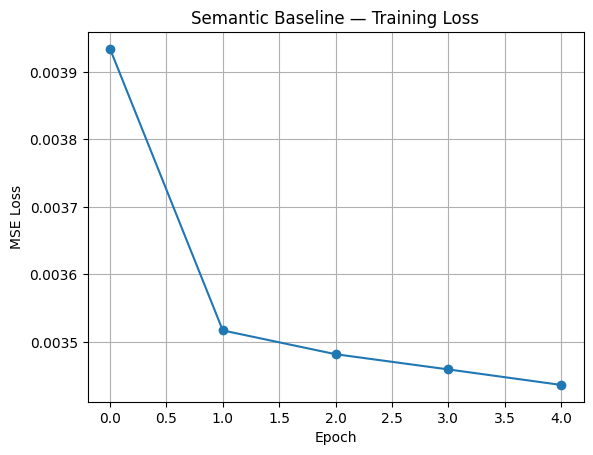

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, marker='o')
plt.title("Semantic Baseline — Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()
plt.show()


#  Visualizing Predictions
We inspect a few random frames:
- True word embedding vs Predicted
- Cosine similarity
- The top-5 nearest words for each prediction


In [ ]:
import random

def show_example(idx):
    eeg, target = test_dataset[idx]
    eeg_t = eeg.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(eeg_t).cpu().numpy()[0]

    true_vec = target.numpy()

    cos = cosine_similarity(pred.reshape(1,-1), true_vec.reshape(1,-1))[0,0]

    sims = cosine_similarity(pred.reshape(1,-1), vocab_matrix)[0]
    top5_idx = np.argsort(-sims)[:5]

    print("Frame index:", idx)
    print("Cosine similarity:", cos)
    print("\nTop-5 predicted words:")
    for i in top5_idx:
        print(vocab_words[i], " | sim =", sims[i])

# Show 5 random examples
for _ in range(5):
    show_example(random.randint(0, len(test_dataset)-1))
    print("----------------------------------")


Frame index: 500
Cosine similarity: 0.3767007

Top-5 predicted words:
totdat  | sim = 0.639997937687454
onmiddellijk  | sim = 0.6280697901305785
wanneer  | sim = 0.6269559859499132
alsof  | sim = 0.6121247396250481
nu  | sim = 0.5990052800713067
----------------------------------
Frame index: 1212
Cosine similarity: 0.4027484

Top-5 predicted words:
nu  | sim = 0.6780379266361799
totdat  | sim = 0.6721328825582311
maar  | sim = 0.6583266594748358
nog  | sim = 0.6565636695396428
daarna  | sim = 0.6444708651204063
----------------------------------
Frame index: 1340
Cosine similarity: 0.6418376

Top-5 predicted words:
totdat  | sim = 0.6748766731123363
nu  | sim = 0.6657373939007564
nog  | sim = 0.643280628800704
maar  | sim = 0.6418376006384124
daarna  | sim = 0.6377803140440255
----------------------------------
Frame index: 198
Cosine similarity: 0.32941622

Top-5 predicted words:
totdat  | sim = 0.668736253816232
nu  | sim = 0.6613136542752068
nog  | sim = 0.6572317897204436
daarna  

#  Prediction vs Ground-Truth (Frame-level inspection)

For several random test samples, we display:
- The true semantic vector (Word2Vec)
- The predicted vector from the model
- Cosine similarity
- The top-5 closest predicted words
- The true nearest word from vocabulary

This helps confirm whether the semantic model is learning real meaning.


In [ ]:
import random
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

device = torch.device("cpu")
model.eval()

# Build vocab matrix once
vocab_words = list(word2vec.keys())
vocab_matrix = np.stack([word2vec[w] for w in vocab_words], axis=0)

def inspect_example(i):
    # Get EEG + true word vector
    eeg, target = test_dataset[i]

    eeg_t = eeg.unsqueeze(0).to(device)
    target_vec = target.numpy()

    # Model prediction
    with torch.no_grad():
        pred_vec = model(eeg_t).cpu().numpy()[0]

    # Cosine similarity GT vs Pred
    cos = float(cosine_similarity(pred_vec.reshape(1, -1),
                                  target_vec.reshape(1, -1))[0, 0])

    # Top-5 nearest predicted words
    sims = cosine_similarity(pred_vec.reshape(1, -1), vocab_matrix)[0]
    top5_idx = np.argsort(-sims)[:5]

    # True closest word in vocabulary
    true_idx = np.argmax(cosine_similarity(
        target_vec.reshape(1, -1), vocab_matrix
    ))

    true_word = vocab_words[true_idx]

    print("=============================================")
    print("Frame index:", i)
    print("Cosine similarity:", round(cos, 4))
    print("---------------------------------------------")
    print("True nearest vocab word:", true_word)
    print("---------------------------------------------")
    print("Top-5 predicted words:")
    for j in top5_idx:
        print(f"{vocab_words[j]:15s} | sim = {sims[j]:.4f}")
    print("=============================================\n")

# Show 5 random examples
for _ in range(5):
    inspect_example(random.randint(0, len(test_dataset)-1))


Frame index: 846
Cosine similarity: 0.5955
---------------------------------------------
True nearest vocab word: naar
---------------------------------------------
Top-5 predicted words:
hem             | sim = 0.7825
redetwisten     | sim = 0.7794
wanneer         | sim = 0.7624
maar            | sim = 0.7620
onmiddellijk    | sim = 0.7580

Frame index: 224
Cosine similarity: 0.6305
---------------------------------------------
True nearest vocab word: zich
---------------------------------------------
Top-5 predicted words:
maar            | sim = 0.8526
nu              | sim = 0.8167
totdat          | sim = 0.8136
al              | sim = 0.8131
nog             | sim = 0.8123

Frame index: 955
Cosine similarity: 0.5319
---------------------------------------------
True nearest vocab word: door
---------------------------------------------
Top-5 predicted words:
maar            | sim = 0.8497
nu              | sim = 0.8061
dat             | sim = 0.8059
niet            | sim = 0.8044


# Save Model and Cleaned Semantic Data
We store the trained model and cleaned dataset for later use
in the tri-modal system.


In [ ]:
# Save model weights
torch.save(model.state_dict(), "semantic_baseline.pth")

# Save cleaned dataset
np.save("semantic_eeg_clean.npy", eeg_clean)
np.save("semantic_labels_clean.npy", labels_clean)
np.save("semantic_targets_clean.npy", targets)

print("Saved: semantic_baseline.pth + cleaned semantic arrays.")


Saved: semantic_baseline.pth + cleaned semantic arrays.


In [ ]:
sorted(list(set(labels_clean)))


[np.str_('aan'),
 np.str_('al'),
 np.str_('alsof'),
 np.str_('bakker'),
 np.str_('betovering'),
 np.str_('bevrijd'),
 np.str_('buurt'),
 np.str_('daarna'),
 np.str_('dak'),
 np.str_('dan'),
 np.str_('dat'),
 np.str_('dauwdruppel'),
 np.str_('deur'),
 np.str_('dichtbij'),
 np.str_('die'),
 np.str_('direct'),
 np.str_('donkere'),
 np.str_('doodsbang'),
 np.str_('door'),
 np.str_('en'),
 np.str_('er'),
 np.str_('geen'),
 np.str_('gefluit'),
 np.str_('haar'),
 np.str_('had'),
 np.str_('helemaal'),
 np.str_('helft'),
 np.str_('hem'),
 np.str_('hierop'),
 np.str_('hij'),
 np.str_('hoe'),
 np.str_('hun'),
 np.str_('in'),
 np.str_('kin'),
 np.str_('komt'),
 np.str_('kwamen'),
 np.str_('lij'),
 np.str_('maar'),
 np.str_('meisjes'),
 np.str_('mij'),
 np.str_('mijn'),
 np.str_('moment'),
 np.str_('mooi'),
 np.str_('naar'),
 np.str_('nachtegalen'),
 np.str_('niet'),
 np.str_('nog'),
 np.str_('nu'),
 np.str_('of'),
 np.str_('onmiddellijk'),
 np.str_('onschuldig'),
 np.str_('ook'),
 np.str_('over'),

CONFUSION-LIKE HEATMAP
(Word2Vec similarity between ground-truth words & predicted vectors)

Goal:
We build a matrix:

matrix[word_i][word_j] = cosine( prediction_for_word_i , word2vec(word_j) )


In [ ]:
from torch.utils.data import DataLoader

full_dataset = SemanticFrameDataset(eeg_clean, targets)   # all 6879 frames
full_loader  = DataLoader(full_dataset, batch_size=64)

model.eval()
all_preds = []

with torch.no_grad():
    for eeg_batch, _ in full_loader:
        eeg_batch = eeg_batch.to(device)
        pred_vecs = model(eeg_batch).cpu().numpy()
        all_preds.append(pred_vecs)

preds = np.vstack(all_preds)
print("Preds shape:", preds.shape)


Preds shape: (6879, 160)


Unique words: 86


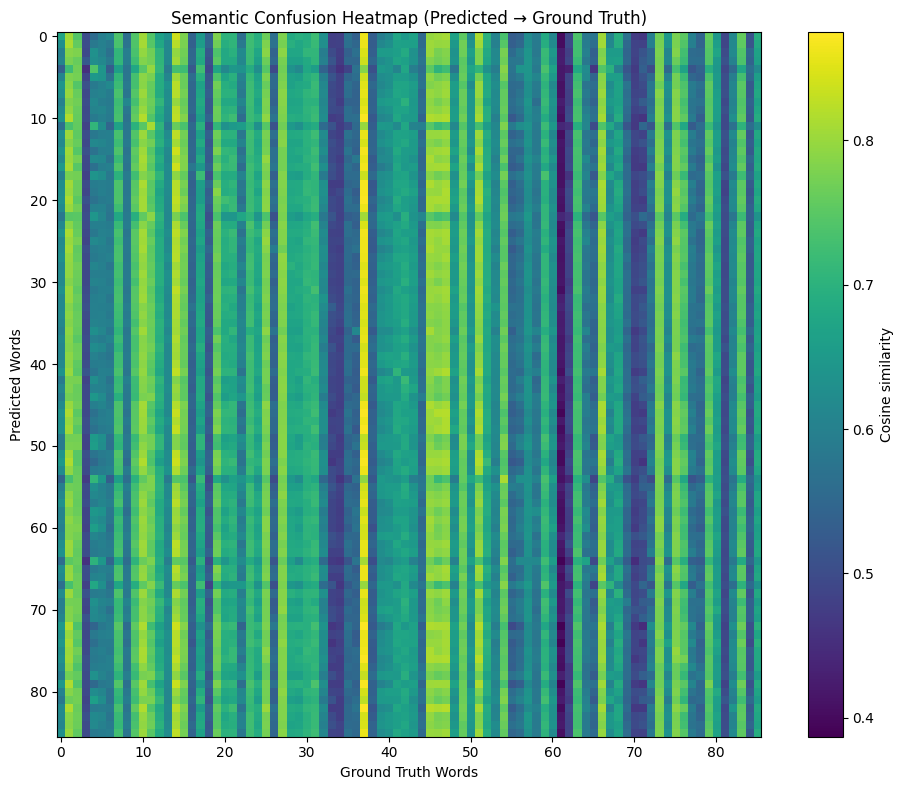

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# ===== Prepare mapping =====
unique_words = sorted(list(set(labels_clean)))
num_words = len(unique_words)


print("Unique words:", num_words)

# Create vector for GT Word2Vec
gt_vectors = np.stack([word2vec[w] for w in unique_words])

# Compute mean predicted embeddings per word
pred_vectors = []
for w in unique_words:
    idx = np.where(labels_clean == w)[0]
    pred_vectors.append(preds[idx].mean(axis=0))
pred_vectors = np.stack(pred_vectors)

# ===== Build similarity matrix =====
sim_matrix = cosine_similarity(pred_vectors, gt_vectors)

plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='viridis')
plt.colorbar(label="Cosine similarity")
plt.title("Semantic Confusion Heatmap (Predicted → Ground Truth)")
plt.xlabel("Ground Truth Words")
plt.ylabel("Predicted Words")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from collections import defaultdict

# Convert labels_clean to numpy array if not yet
labels_clean = np.array(labels_clean)

# List of unique words used by the subject
unique_words = np.unique(labels_clean)

# Prepare structures
gt_per_word = []
preds_per_word = []

for w in unique_words:
    # indices for all frames belonging to this word
    idx = np.where(labels_clean == w)[0]

    # GT: same Word2Vec vector for all frames, so we just take one
    gt_vec = word2vec[w]
    gt_per_word.append(gt_vec)

    # Pred: average predicted vector for frames where this word appears
    pred_vec = preds[idx].mean(axis=0)
    preds_per_word.append(pred_vec)

# Convert to numpy arrays
gt_per_word = np.vstack(gt_per_word)          # shape (num_words, 160)
preds_per_word = np.vstack(preds_per_word)    # shape (num_words, 160)

print("gt_per_word:", gt_per_word.shape)
print("preds_per_word:", preds_per_word.shape)
print("unique_words:", unique_words.shape)


gt_per_word: (86, 160)
preds_per_word: (86, 160)
unique_words: (86,)


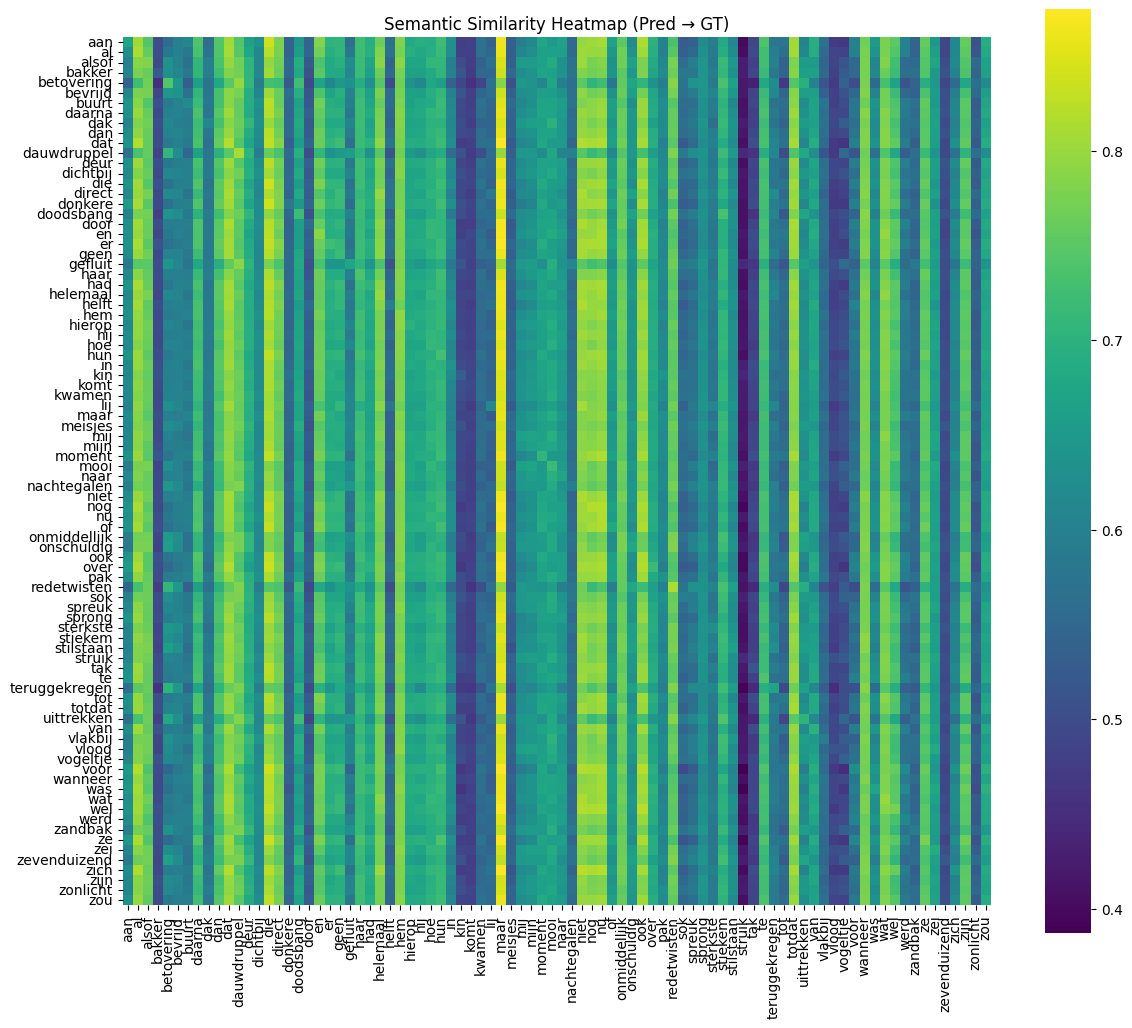

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Convert list to numpy array
unique_words = np.array(unique_words)

# Alphabetically sort
sorted_idx = np.argsort(unique_words)

words_sorted = unique_words[sorted_idx]
gt_sorted = gt_per_word[sorted_idx]
pred_sorted = preds_per_word[sorted_idx]

# Similarity matrix (Pred → GT)
sim_matrix = cosine_similarity(pred_sorted, gt_sorted)

plt.figure(figsize=(14, 12))
sns.heatmap(sim_matrix, cmap="viridis",
            xticklabels=words_sorted,
            yticklabels=words_sorted,
            square=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Semantic Similarity Heatmap (Pred → GT)")
plt.show()


Compute similarity scores per word

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# similarity(pred, gt) for each word
sim_scores = np.array([
    cosine_similarity(preds_per_word[i:i+1], gt_per_word[i:i+1])[0, 0]
    for i in range(len(unique_words))
])

# Sort by best similarity (descending)
top20_idx = np.argsort(sim_scores)[-20:][::-1]

top20_words = unique_words[top20_idx]
gt_top20 = gt_per_word[top20_idx]
pred_top20 = preds_per_word[top20_idx]

print("Top-20 words:", top20_words)
print("Shape:", gt_top20.shape, pred_top20.shape)


Top-20 words: ['maar' 'die' 'dat' 'nog' 'nu' 'niet' 'redetwisten' 'al' 'ook' 'totdat'
 'dauwdruppel' 'wat' 'helemaal' 'hem' 'en' 'direct' 'wanneer' 'alsof'
 'onmiddellijk' 'ze']
Shape: (20, 160) (20, 160)


In [ ]:
# 20×20 Cosine Similarity Matrix
sim_top20 = cosine_similarity(pred_top20, gt_top20)



Plot clean Top-20 heatmap

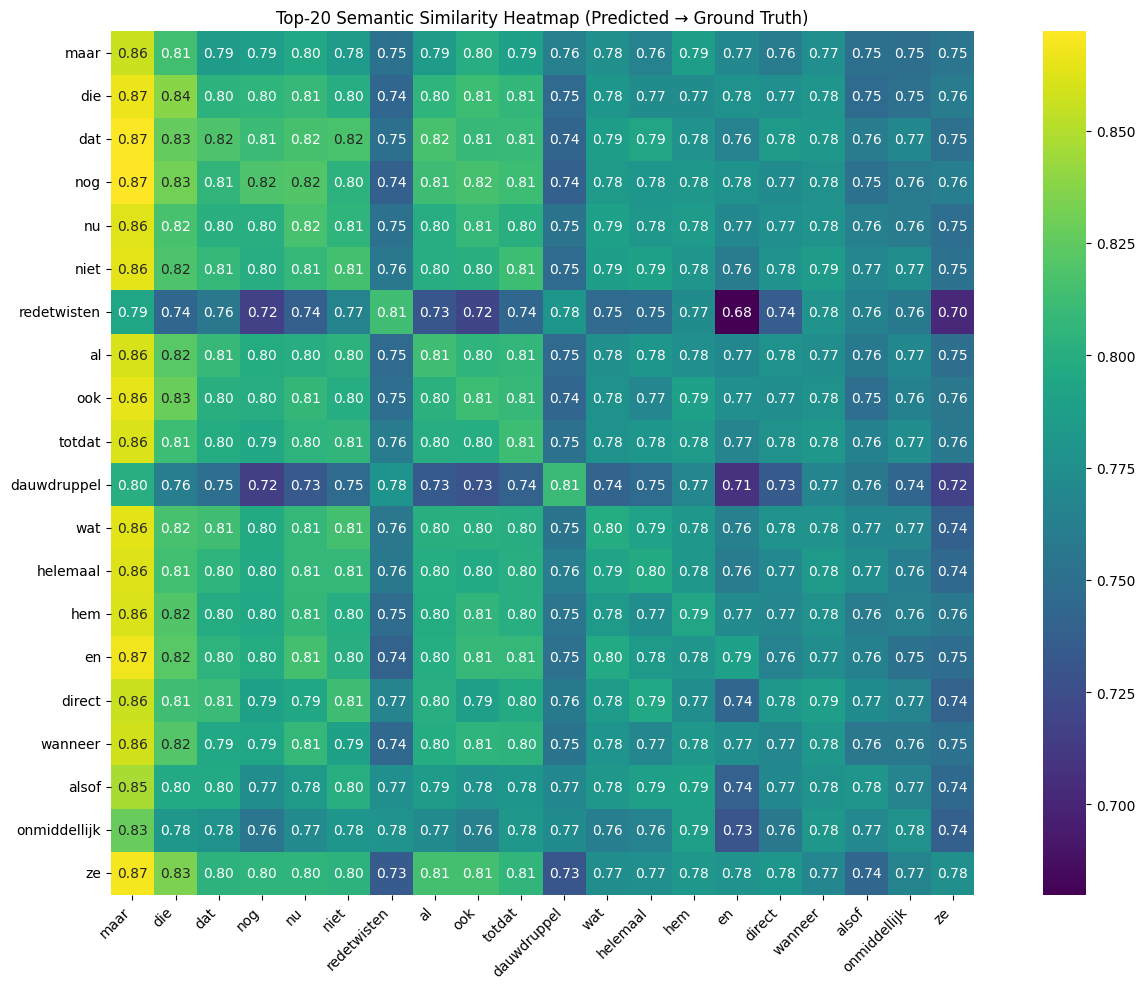

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))

sns.heatmap(
    sim_top20,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    xticklabels=top20_words,
    yticklabels=top20_words,
    square=True
)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Top-20 Semantic Similarity Heatmap (Predicted → Ground Truth)")
plt.tight_layout()
plt.show()


In [ ]:
import torch

# Convert full EEG dataset to tensor
eeg_tensor = torch.tensor(eeg_clean, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    pred_semantic = model(eeg_tensor).cpu().numpy()

print("Predicted semantic vectors:", pred_semantic.shape)


Predicted semantic vectors: (6879, 160)


Correlation between frequency and prediction quality:
r = 0.192,  p = 0.07665


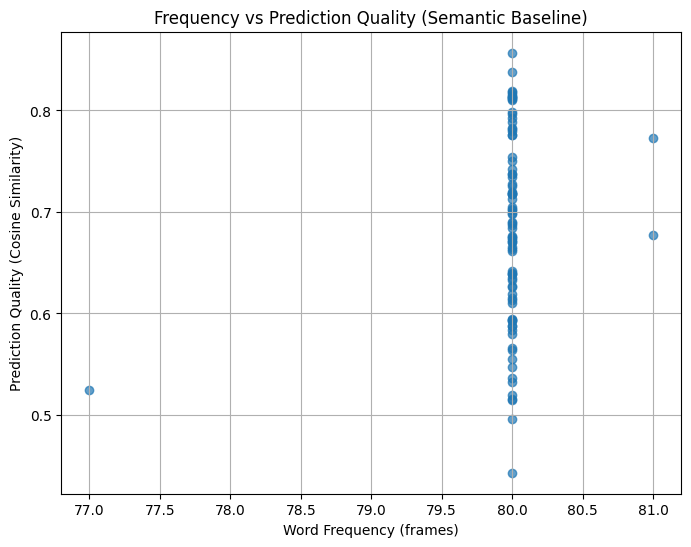

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Convert list to numpy
labels_np = np.array(labels_clean)

unique_words = np.unique(labels_np)

freqs = []
qualities = []

for w in unique_words:
    idx = np.where(labels_np == w)[0]

    # frequency
    freq = len(idx)

    # average predicted vector for this word
    pred_mean = pred_semantic[idx].mean(axis=0)

    # ground truth vector
    gt_vec = word2vec[w]

    # cosine similarity prediction quality
    sim = np.dot(pred_mean, gt_vec) / (np.linalg.norm(pred_mean) * np.linalg.norm(gt_vec))

    freqs.append(freq)
    qualities.append(sim)

# Convert to arrays
freqs = np.array(freqs)
qualities = np.array(qualities)

# Correlation
corr, pval = pearsonr(freqs, qualities)

print("Correlation between frequency and prediction quality:")
print(f"r = {corr:.3f},  p = {pval:.5f}")

# ---- Plot ----
plt.figure(figsize=(8,6))
plt.scatter(freqs, qualities, alpha=0.7)
plt.xlabel("Word Frequency (frames)")
plt.ylabel("Prediction Quality (Cosine Similarity)")
plt.title("Frequency vs Prediction Quality (Semantic Baseline)")
plt.grid(True)
plt.show()
